# Image Classification using Convolutional Neural Network (CNN)

This project is based on the following tutorials by
1. [Venlin Valkov](https://medium.com/@curiousily/tensorflow-for-hackers-part-iii-convolutional-neural-networks-c077618e590b)
2. [sentdex](https://pythonprogramming.net/convolutional-neural-network-kats-vs-dogs-machine-learning-tutorial/?source=post_page-----81eef880715e----------------------)
2. [Connor Shorten](https://towardsdatascience.com/how-to-build-a-convolutional-network-classifier-81eef880715e)

## Overview
The project is a classifier that would distinguish between Nike and Adidas basketball shoes using [tflearn](http://tflearn.org) API (Application programming interface) to build image recognition model.  

## Dataset
Data contains 50 images of for each Nike and Adidas shoe designs, both for the [test](https://github.com/CShorten/NIKE_vs_ADIDAS/tree/master/TEST) and [training](https://github.com/CShorten/NIKE_vs_ADIDAS/tree/master/TRAIN) data. 

## Model details
I decided to use 4-layer convolutional networks, learning rate as 0.001 which should be optimal for the ADAM (Adaptive Moment Estimation) optimizer. [ADAM](https://towardsdatascience.com/adam-latest-trends-in-deep-learning-optimization-6be9a291375c) is a combination of RMSprop and Stochastic Gradient Descent with momentum for back propagation.


- LR: The learning rate is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated. A rate value too small may result in a long training process that could get stuck, whereas a value too large may result in learning a sub-optimal set of weights too fast or an unstable training process. 

## Dependencies 

- `PIL`: For image pre-processing, mainly resizing. One can equally use opencv for the purpose, or try more advance features of tflearn library as `tflearn.data_preprocessing.ImagePreprocessing` and `tflearn.data_augmentation.ImageAugmentation`. 

- `numpy`: To deal with arrays

- `os`: To deal with directories

- `shuffle`: To mix up the images, since the currently ordered data might lead our network astray in training.

- `tdqm` : A progress bar for tasks, used in any for loop

- `matplotlib` : To plot the images


In [64]:
from PIL import Image          
import numpy as np             
import os                      
from random import shuffle     
from tqdm import tqdm
import matplotlib.pyplot as plt
TRAIN_DIR = 'TRAIN'
TEST_DIR = 'TEST'

IMG_SIZE = 120
LR = 1e-3

MODEL_NAME = 'NIKEvsADIDAS--{}-{}.model'.format(LR, '6conv-basic')

## Label the data

We first label data using one hot encoding, which is to perform “binarization” of the categories. For each name of the image, we assign a vector such as Nike is [1 0] and Adidas is [0 1]. Say if we have three types of categories, Nike, Adidas, Reebok, then encoding can be Nike as [1 0 0], and Adidas as [0 1 0], and Reebok as [0 0 1].

In [65]:
def label_img(img):
    # Images are formatted as: ADIDAS_1, NIKE_3 ...
    word_label = img.split('_')[0]
    if word_label == 'NIKE': return [1,0]
    elif word_label == 'ADIDAS': return [0,1]

## Pre-processing the data
We will be resizing images with size 120 x 120 for better quality, and will compensate the computational time by coverting images into gray scale. The square images will be bit distorted but the three stripes from adidas and nike swoosh will be still clearly visible that is the key feature to train our model. After resizing, we will convert the images and labels into arrays that will be passed through our network. A computer sees an image as an array of pixel values, which in our case is 120 x 120 (since, we reduce from RGB to gray scale). Each of these numbers is given a value from 0 to 255 (8-bit integer) which describes the pixel intensity at that point. We will do the same treatment to the test data, but instead of adding a label to each image, we will only add a number for each image.

In [66]:
def create_train_data():
    '''
    Creates a numpy array of images and its labels (one hot encoding)
    Returns:
        Returns a numpy array of images that are matrices (IMG_SIZE x IMG_SIZE) and the labels that are vector (1x2).
    '''
    train_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)        
        path = os.path.join(TRAIN_DIR, img)        
        
        img = Image.open(path) 
        img = img.convert('L') 
        img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
        
        train_data.append([np.array(img), np.array(label)])
    shuffle(train_data)
    np.save('train_data.npy', train_data) 
    return train_data

In [67]:
def process_test_data():
    '''
    Creates a numpy array of images and its index
    Returns:
        Returns a numpy array of images that are matrices (IMG_SIZE x IMG_SIZE) and the index.
    '''
    test_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR, img)
        if "DS_Store" not in path:
            img_num = img.split('_')[1] #images are formatted 'NIKE_2', 'ADIDAS_56'..

            img = Image.open(path)
            img = img.convert('L')
            img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
        
            test_data.append([np.array(img), img_num])
    shuffle(test_data)
    np.save('test_data.npy', test_data)
    return test_data

In [68]:
train_data = create_train_data()

100%|██████████| 100/100 [00:00<00:00, 293.36it/s]


## Data Inspection 
We can either open the saved `numpy` array or look at the return array of the method `create_train_data()`. This is more to understand the data structure that will be passed to the layers.

In [69]:
train_data_inspect = np.load('train_data.npy',allow_pickle=True)
print('dimensions of trained data:', train_data_inspect.shape)  
#for i, row in enumerate(train_data_inspect): print(row[0].shape,'-->', row[1])

dimensions of trained data: (100, 2)


The dimensions of the trained data tells us a tensor of rank 2, with shape = (100, 2). For each of the 100 images, the first row is a 120 x 120 matrix (with values from 0 to 255) and second row is a vector of size 2 (with values 0 or 1). 

Lets check if image corresponds to the right label. I first print the indicies of the arrays that corresponds to adidas and nike images, and then plot the image to varify it against that list.


 nike indices:    [1, 4, 5, 6, 7, 8, 9, 11, 12, 14, 15, 16, 17, 18, 19, 20, 28, 29, 31, 33, 35, 39, 41, 42, 43, 44, 47, 49, 50, 52, 53, 55, 58, 63, 66, 67, 69, 71, 72, 74, 75, 78, 79, 82, 83, 84, 85, 86, 87, 95] 

 adidas indices: [0, 2, 3, 10, 13, 21, 22, 23, 24, 25, 26, 27, 30, 32, 34, 36, 37, 38, 40, 45, 46, 48, 51, 54, 56, 57, 59, 60, 61, 62, 64, 65, 68, 70, 73, 76, 77, 80, 81, 88, 89, 90, 91, 92, 93, 94, 96, 97, 98, 99]

 label: [0 1]


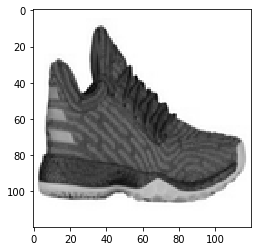

In [70]:
nike = [i for (i, row) in  enumerate(train_data_inspect) if (row[1][0] == 1 and row[1][1] == 0)] 
adidas = [i for (i, row) in  enumerate(train_data_inspect) if (row[1][0] == 0 and row[1][1] == 1)] 
print('\n nike indices:   ', nike, '\n\n adidas indices:', adidas)
# Lets visualize the 100th image
plt.imshow(train_data[99][0], cmap = 'gist_gray')
print('\n label:', train_data[99][1])

## Model building

ConvNets matches feature of the images. To build our model, we choose 6 deep layers. The first layer is always a convolutional layer, which will choose with 32 filters, stride = 5 with relu activation, and finally followed by max pool layer ith stride=5. What does it mean?

The first layer can be think as convolutions of 32 x 32 sliding lense that are “activated” when are placed above a corner of an input image (120 x 120) with the feature that is familiar to them. During sliding, or convolving, around the input image, a filter is multiplying its values with the original pixel values of the image (aka computing element wise multiplications). These multiplications are all summed up in a single number (mathematically speaking, this would be 1024 multiplications in total). The filter then slides on next set of 32 x 32 pixel, and another value is stored in what is called a feature map (120 x 120 x 32).  Next ReLu activation is used, that convert every negative number to 0 to keep the math simple. After that, a convolution layer which is a stack of all filtered images is pooled or shrinked. As in our case, from a 5 x 5 window on a filtered image, the maximum value is picked and stored into 1 pixel of a new filtered image. Next, we keep striding with a step of 5 and picking the maximum value from the next 5 x 5 window. This procedure is called maximum pooling. This way a stack of images becomes a stack of smaller images (24 x 24 x 32). This output of new stack of images or layer now becomes the input to the next layer. Each time, the image gets more filtered as it goes through a convolution layer, and smaller as it goes through the pooling layers. The final layer is called the fully connected layer (1 x 1 x 64), such as every value gets a vote. The dropout layer has 1024 cells. The value of each cell connects to our answers that we will be voting for. The value determines how strongly a value predicts the image as if its Nike or Adidas.

The error on the final answer is backpropagated that teaches the network as how much it should adjust. This can be thought of an adjusted error descenting up or down from a weight in a valley. We want to go down that gradient where there is very least error.

In [71]:
import tflearn.datasets.mnist as mnist
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

import tensorflow as tf
tf.reset_default_graph()

# Input is a 120x120 image 
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name = 'input')

# first layer
convnet = conv_2d(convnet, 32, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)

# second layer (hidden)
convnet = conv_2d(convnet, 64, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)

# third layer (hidden)
convnet = conv_2d(convnet, 32, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)

# fourth layer (hidden)
convnet = conv_2d(convnet, 64, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)

# fifth layer (hidden)
convnet = conv_2d(convnet, 32, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)

# sixth layer
convnet = conv_2d(convnet, 64, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)

# fully connected layer
convnet = fully_connected(convnet, 1024, activation = 'relu')
convnet = dropout(convnet, 0.8)

#output layer
convnet = fully_connected(convnet, 2, activation = 'softmax')

convnet = regression(convnet, optimizer = 'adam', learning_rate = LR, loss = 'categorical_crossentropy', name = 'targets')

# Wrap the network in a model object
model = tflearn.DNN(convnet, tensorboard_verbose=3, tensorboard_dir='log')
#model.save('mnist.tflearn')
#model.load('mnist.tflearn')

## Data Splitting and Reformatting

I will be using 90% of the data for training and rest for testing, since I do not have enough data. Lets also format the data such as matrices for training with shape (120, 120) are reshaped as (90, 120, 120, 1), since during image processing, many tensors of rank 4 are used, with dimensions corresponding to example-in-batch, image width, image height, and color channel. Similarly, the target data Y is formatted in single array of an array of size 2.

In [72]:
train = train_data[-90:] #Train Set
test = train_data[:-90]  #Validation Set

X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_y = [i[1] for i in test]

## Fit Model

We choose 100 epoches (`n_epochs=100`), where one epoch is define when an entire dataset is passed both forward and backward through the neural network only once. We choose to snapshot the network at every 50th step (`snapshot_step=50`) to calculate validation loss/accuracy and to save model to a `checkpoint_path`. We use the default batch size (`batch_size=128`).  

In [73]:
model.fit({'input': X}, {'targets': Y}, n_epoch=100, validation_set=({'input': test_x}, {'targets': test_y}), snapshot_step=50, show_metric=True, run_id='NIKE_ADIDAS')

Training Step: 199  | total loss: 0.44714 | time: 6.385s
| Adam | epoch: 100 | loss: 0.44714 - acc: 0.8608 -- iter: 64/90
Training Step: 200  | total loss: 0.41888 | time: 9.940s
| Adam | epoch: 100 | loss: 0.41888 - acc: 0.8747 | val_loss: 0.30466 - val_acc: 0.9000 -- iter: 90/90
--


## Test the trained model on unlabelled data

According to this evaluation we have about 87% accuracy. Next, we would like to test the model prediction (probabilities) on the unlabelled test data.

100%|██████████| 40/40 [00:00<00:00, 282.54it/s]


prob: [0.8711422  0.12885778]
prob: [0.804485   0.19551507]
prob: [0.875438   0.12456201]
prob: [0.7738817  0.22611833]
prob: [0.29263324 0.70736676]
prob: [0.8921721  0.10782786]
prob: [0.62470466 0.37529534]
prob: [0.16324805 0.83675194]
prob: [0.8676623  0.13233767]
prob: [0.79221684 0.20778324]
prob: [0.91034836 0.08965159]
prob: [0.24127486 0.75872517]


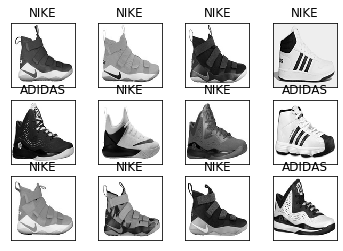

In [76]:
test_data = process_test_data()
fig = plt.figure()

for num, data in enumerate(test_data[:12]):
    img_num = data[1]
    img_data = data[0]
    
    canvas = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1) #(120, 120, 1)
    model_out = model.predict([data])[0]
    label_out = model.predict_label([data])[0]
    print('prob:', model_out)
    if np.argmax(model_out) == 1:
        str_label = 'ADIDAS'
    else:
        str_label = 'NIKE'
    
    canvas.imshow(orig, cmap = 'gray')
    plt.title(str_label)
    canvas.axes.get_xaxis().set_visible(False)
    canvas.axes.get_yaxis().set_visible(False)
plt.show()

# Visualizing the metrics

We can now look at the tensorboard to visualize the updating of parameters. I have been saving the computation graphs in a log directory `log/NIKE_ADIDAS`. To open the tensor board in browser, type the following in the terminal.

```tensorboard --logdir=log/NIKE_ADIDAS/ --host localhost --port 6006```

Your terminal will show the output as

```TensorBoard 1.10.0 at http://localhost:6006 (Press CTRL+C to quit)```

If you have several of the metagraph stored, the latest timestamp one will be picked. Next, type the http address to your browser, and run the following command in your terminal.

```tensorboard --logdir .```
 
Refresh the browser and you will see a graph. For my specific test, my browser node is <http://localhost:6006/#graphs&run=.>
